In [3]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
train_data = pd.read_csv('./competitive-data-science-predict-future-sales/sales_train.csv'); # 2013년 1월부터 2015년 10월까지 
test_data  = pd.read_csv('./competitive-data-science-predict-future-sales/test.csv'); # 2015년 11월의 shop과 product의 판매량을 예측하고 싶은것
submission = pd.read_csv('./competitive-data-science-predict-future-sales/sample_submission.csv'); # 이런형식으로 제출
items      = pd.read_csv('./competitive-data-science-predict-future-sales/items.csv'); # item과 product의 보충정보들
item_categories  = pd.read_csv('./competitive-data-science-predict-future-sales/item_categories.csv');
shops      = pd.read_csv('./competitive-data-science-predict-future-sales/shops.csv');
#item_cnt_day = 팔린 제품의 수/판매된 제품 수 월별 금액. 이걸로 매달 판매량 예측할 것.
#date_block_num = 편의를 위해 연속된 월번호 / 2013년 1월은 0, 2013년 2월은 2 ~ 2015년 10월을 33
train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
train_data.isnull().sum() 
# 결측치 없음

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
sum(train_data.duplicated()), sum(test_data.duplicated())

(6, 0)

In [7]:
sum(items.duplicated()), sum(item_categories.duplicated()), sum(shops.duplicated())

(0, 0, 0)

In [8]:
train_data[train_data.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [9]:
# train data에 중복 행이 6개 있으므로 제거해줌. 여기서 중복 제거 안하고 넘어가게 되면 나중에 merge할 때 문제 발생
train_data.drop_duplicates(inplace=True)

# 이상치 제거

<AxesSubplot:xlabel='item_price'>

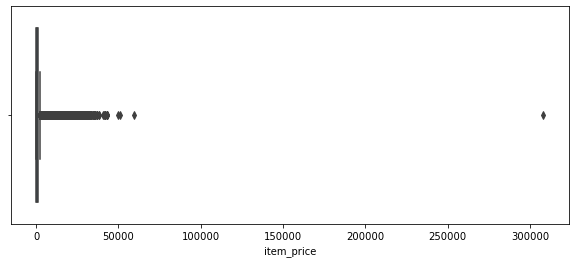

In [10]:
plt.figure(figsize = (10,4))
sns.boxplot(x=train_data.item_price)

<AxesSubplot:xlabel='item_cnt_day'>

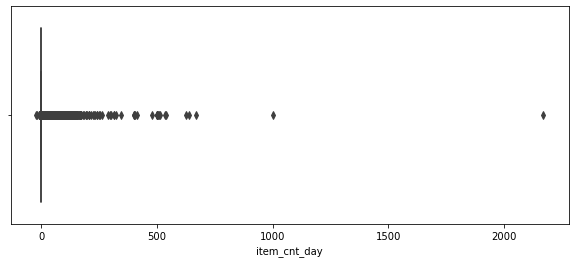

In [11]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train_data.item_cnt_day)

In [12]:
train_data = train_data[train_data.item_price<100000]
train_data = train_data[train_data.item_cnt_day<1001]

In [13]:
train_data = train_data[train_data.item_price >= 0]
train_data = train_data[train_data.item_cnt_day >= 0]

train 데이터의 item_price, item_cnt_dat 박스플롯 확인결과 이상치가 존재하므로 제거해주기로 한다. 
또한 두 피처에 대해서 0보다 작은 데이터가 있으므로 제거해주기로 한다.

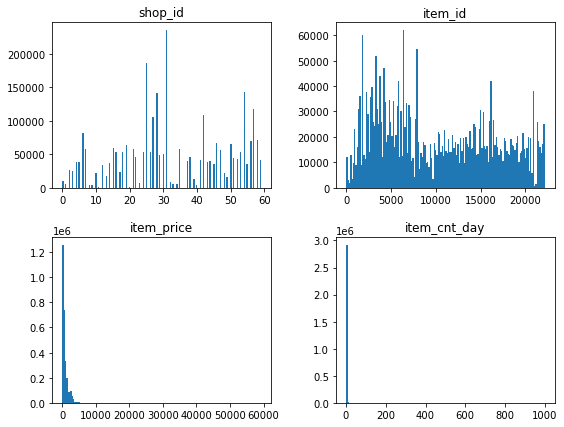

In [14]:
train_data[['shop_id','item_id','item_price','item_cnt_day']].hist(bins=150,figsize=(9,7),grid=False);

In [15]:
# Merging dataset(Train set)

dataFrame = train_data.copy()
dataFrame

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [16]:
dataFrame=pd.merge(item_categories,items ,how='inner',on='item_category_id')
dataFrame=pd.merge(dataFrame,train_data,how='inner',on='item_id')
dataFrame=pd.merge(dataFrame,shops,how='inner',on='shop_id')

# dataFrame에 있는 것들중 각각 train_data랑 shops에 있는거랑 겹치는거 merge
dataFrame

,item_category_name,item_category_id,item_name,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name
0,PC - Гарнитуры/Наушники,0,Наушники PHILIPS SBC HC8680,16255,28.02.2013,1,0,93.00,1.0,"!Якутск Орджоникидзе, 56 фран"
1,Аксессуары - PS2,1,Pelican. Геймпад Nerf Wireless Controller PS2 ...,5740,20.02.2013,1,0,283.00,1.0,"!Якутск Орджоникидзе, 56 фран"
2,Аксессуары - PS3,2,PS Move Controller (Контроллер движений),5570,28.02.2013,1,0,93.00,1.0,"!Якутск Орджоникидзе, 56 фран"
3,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,04.01.2013,0,0,1322.00,3.0,"!Якутск Орджоникидзе, 56 фран"
4,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,05.01.2013,0,0,1322.00,2.0,"!Якутск Орджоникидзе, 56 фран"
...,...,...,...,...,...,...,...,...,...,...
2928479,Подарки - Фигурки,72,Фигурка Wolverine Marvel Classic Wolverine Hea...,20886,03.10.2014,21,20,1500.68,1.0,"Москва ""Распродажа"""
2928480,Подарки - Фигурки,72,Фигурка Wolverine Marvel Classic Wolverine Hea...,20886,04.10.2014,21,20,1499.00,3.0,"Москва ""Распродажа"""
2928481,Подарки - Фигурки,72,Фигурка Wolverine Marvel Classic Wolverine Hea...,20886,05.10.2014,21,20,1499.00,6.0,"Москва ""Распродажа"""
2928482,Элементы питания,83,Элемент питания DURACELL LR06-BC2,22088,01.10.2015,33,20,119.00,1.0,"Москва ""Распродажа"""


<AxesSubplot:>

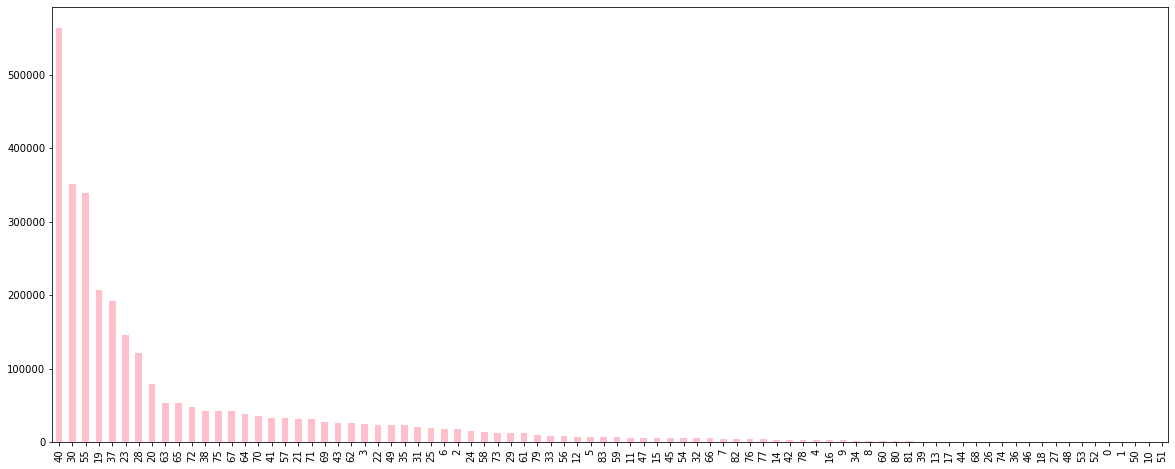

In [17]:
# value_counts()는 어떤 컬럼/Series의 unique value들을 count해주는 함수 -> 각각의 종류 count
dataFrame['item_category_id'].value_counts().plot(kind='bar',color='pink', figsize=(20,8))

<AxesSubplot:ylabel='Frequency'>

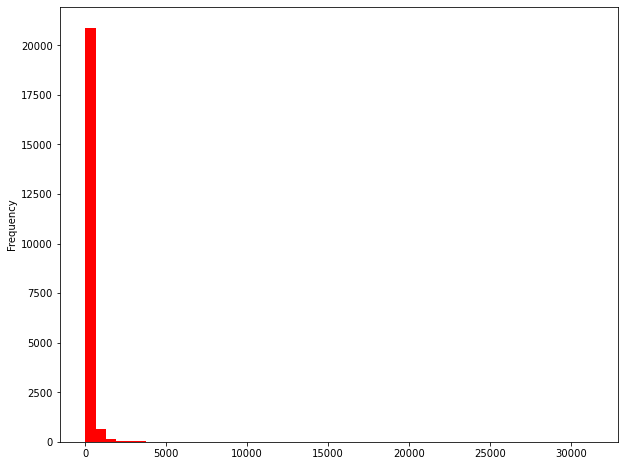

In [16]:
dataFrame['item_name'].value_counts().plot(kind='hist',color='red', figsize=(10,8),bins=50)

<AxesSubplot:ylabel='Frequency'>

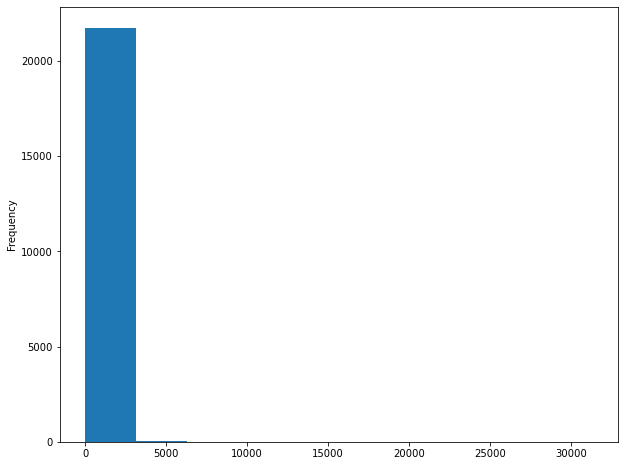

In [17]:
dataFrame['item_id'].value_counts().plot(kind='hist', figsize=(10,8))

<AxesSubplot:ylabel='Frequency'>

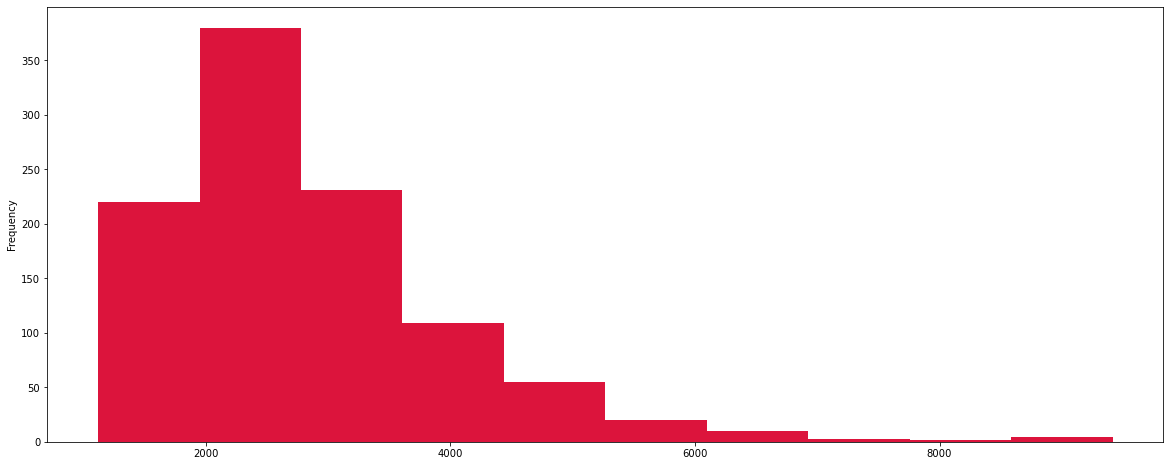

In [18]:
dataFrame['date'].value_counts().plot(kind='hist',color='crimson', figsize=(20,8))

<AxesSubplot:ylabel='date_block_num'>

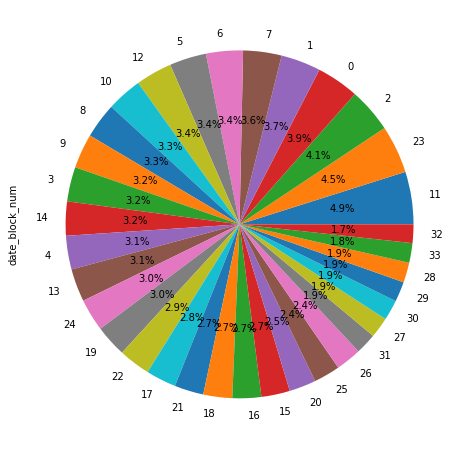

In [19]:
dataFrame['date_block_num'].value_counts().plot(kind='pie',autopct='%1.1f%%', figsize=(20,8))

<AxesSubplot:>

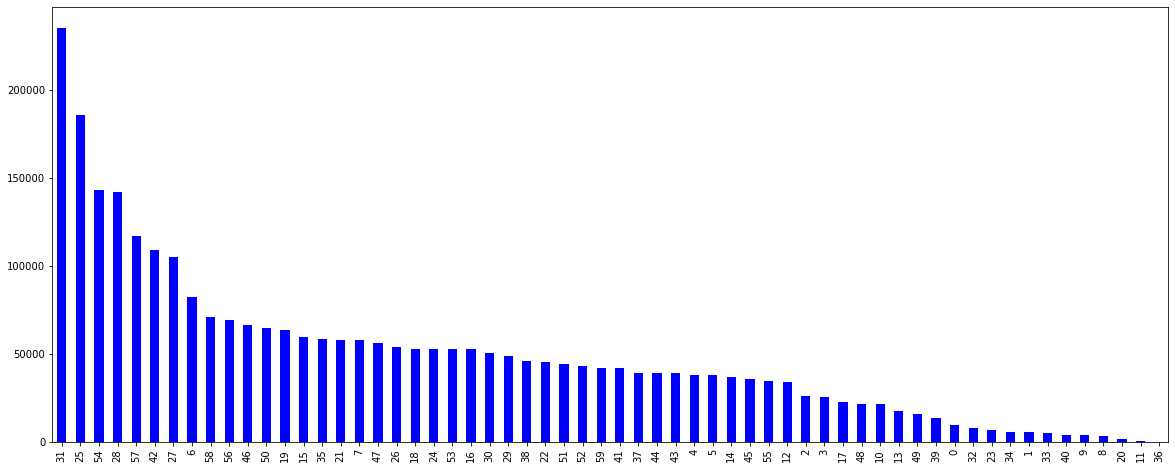

In [20]:
dataFrame['shop_id'].value_counts().plot(kind='bar',color='blue', figsize=(20,8))

<AxesSubplot:ylabel='Frequency'>

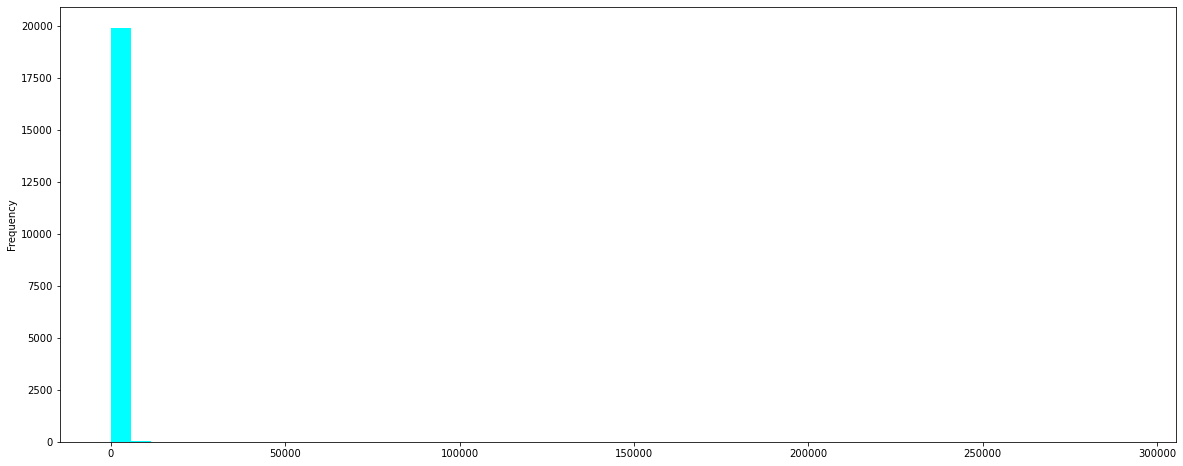

In [21]:
dataFrame['item_price'].value_counts().plot(kind='hist',color='cyan', figsize=(20,8),bins=50)

In [18]:
# data set 분석
dataFrame["date"] = pd.to_datetime(dataFrame["date"],format='%d.%m.%Y');
dataFrame["month"] = dataFrame["date"].dt.month;
dataFrame = dataFrame[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(
    ["date_block_num", "shop_id", "item_id"]).agg(
    {"item_price": "mean","item_cnt_day": "sum", "month": "min"}).reset_index();
dataFrame.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True);




dataFrame = dataFrame.sort_values(by=['date_block_num'], ascending=True).reset_index(drop=True);
dataFrame

,date_block_num,shop_id,item_id,item_price,item_cnt_month,month
0,0,0,32,221.0,6.0,1
1,0,37,18749,149.0,1.0,1
2,0,37,18753,349.0,1.0,1
3,0,37,18761,149.0,1.0,1
4,0,37,18766,149.0,1.0,1
...,...,...,...,...,...,...
1608220,33,24,9356,399.0,1.0,10
1608221,33,24,9355,349.0,3.0,10
1608222,33,24,9337,899.0,1.0,10
1608223,33,24,8738,749.0,2.0,10


In [19]:
dataFrame.corr()
# 상관계수는 -1과 1 사이의 값을 가지고, 0일 경우는 두 변수 간의 선형관계가 전혀 없음.
# 상관계수의 절대값이 클수록 두 변수 간의 상관관계의 정도가 높다고 표현할 수 있음
# 양이 상관관계일 경우에는 양수로, 음의 상관관계일 경우에는 음수로 나타남.
# 0.3과 0.7사이면 뚜렷한 양적 선형관계, 0.7과 1.0 사이는 강한 양적 선형관계

# 대부분 0.1도 안넘는걸 보아 변수 사이의 상관관계는 크게 없는것으로 보임. -> 상관분석보다는 회귀분석에 가까우니까
# 회귀분석 -> 첫째 시점상으로 먼저 발생한 자료와 나중에 발생한 자료 사이에 선후가 분명해야하고, 둘째로 이들 사이에 서로 인과관계가 있을 경우만 회귀분석

,date_block_num,shop_id,item_id,item_price,item_cnt_month,month
date_block_num,1.000000,0.022380,-0.006147,0.093675,0.002262,0.242398
shop_id,0.022380,1.000000,0.024683,-0.023168,0.000422,0.023032
item_id,-0.006147,0.024683,1.000000,-0.120205,-0.011430,0.001591
item_price,0.093675,-0.023168,-0.120205,1.000000,0.025511,0.030531
item_cnt_month,0.002262,0.000422,-0.011430,0.025511,1.000000,0.017391
month,0.242398,0.023032,0.001591,0.030531,0.017391,1.000000


<AxesSubplot:>

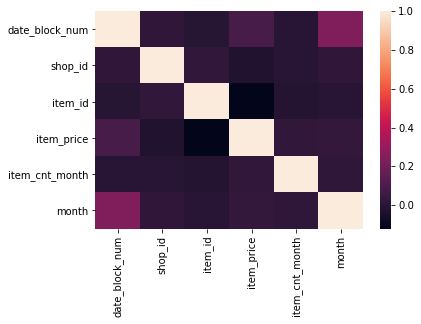

In [24]:
sns.heatmap(dataFrame.corr())

In [20]:
dataFrame.corr()['item_cnt_month'].sort_values()
#sort_values는 오름차순 정렬 

item_id          -0.011430
shop_id           0.000422
date_block_num    0.002262
month             0.017391
item_price        0.025511
item_cnt_month    1.000000
Name: item_cnt_month, dtype: float64

In [21]:
# 각 column별 결측치 갯수 확인
dataFrame.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_month    0
month             0
dtype: int64

In [27]:
# x_train=["shop_id", "item_id"]
# x=dataFrame[x_train]
# y=dataFrame["item_cnt_month"]
# print(x)
# print(y)

In [22]:
# train dataset

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [23]:
# 가게별로, 상품별로(위에서 group 묶었으니까), 매달 판매량 

x_test=test_data[['shop_id','item_id']]

x_train = dataFrame[["shop_id", "item_id"]]
y_train = dataFrame["item_cnt_month"]

In [32]:
# LinearRegression

model=LinearRegression()

lr=model.fit(x_train,y_train)

lr_predict=(model.predict(x_test))
print(lr_predict)

print(x_test.shape)
print(lr_predict.shape)

[2.3494906  2.34509264 2.34644466 ... 2.19732428 2.13685616 2.42713734]
(214200, 2)
(214200,)


In [33]:
from sklearn.metrics import mean_squared_error

print('[linear regression] Train rmse :', np.sqrt(mean_squared_error(y_train, lr.predict(x_train))))

# test rmse가 있으려면.. y_test가 있어야하는데 여기서 그게 없음.

[linear regression] Train rmse : 8.46896128299631


In [34]:
# RandomForestRegressor

model=RandomForestRegressor()

rf=model.fit(x_train,y_train)

rf_predict=(model.predict(x_test))
print(rf_predict)

rf_predict.shape

[1.46505751 6.17776637 2.00721479 ... 1.15404726 1.         1.73683333]


(214200,)

In [ ]:
print('[RandomForest] Train rmse :', np.sqrt(mean_squared_error(y_train, lr.predict(x_train))))

In [34]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [35]:
#xgb

import xgboost as xgb
xg = xgb.XGBRegressor(base_score=0.5,
                      n_estimators=400,
                      min_child_weight=1,
                     max_depth=7,
                     learning_rate=0.1,
                     booster='gbtree',
                     tree_method='exact',
                     reg_alpha=0,
                     subsample=0.5,
                     validate_parameters=1,
                     colsample_bylevel=1,
                     colsample_bynode=1,
                     colsample_bytree=1,
                     gamma=0)
xg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [38]:
pred = xg.predict(x_test)
x_test['item_cnt_day'] = (pred[0]*len(x_test))/len(x_test)

In [40]:
pred

array([2.2348664, 3.3063557, 2.4231644, ..., 1.1881803, 1.1501147,
       1.3139015], dtype=float32)